# Model training and validation pipeline
Now that you have created features, you can use them to train one or more models. In this section, you generate feature vectors with multiple features from one or more feature sets and feed them into an automated ML training and testing pipeline to create high-quality models.

The ML pipeline can be triggered and tracked manually during the interactive development, or it can be saved (into Git) and be executed automatically on a given schedule or as a reaction to different events (such as code modification, CI/CD, data changes, model drift, and so on). See [MLRun project and CI/CD documentation](https://docs.mlrun.org/en/stable/projects/project.html) for details.

## Saving and loading projects from GIT

After you saved your project and its elements (functions, workflows, artifacts, etc.) you can commit all your changes to a 
GIT repository. This can be done using standard GIT tools or using MLRun `project` methods such as `pull`, `push`, 
`remote`, which calls the Git API for you.

Projects can then be loaded from Git using MLRun `load_project` method, for example: 

    project = mlrun.load_project("./myproj", "git://github.com/mlrun/project-demo.git", name=project_name)
    
or using MLRun CLI:

    mlrun project -n myproj -u "git://github.com/mlrun/project-demo.git" ./myproj
    
Projects can be loaded or created by using MLRun `get_or_create_project` method.
    
Read [CI/CD integration](../../projects/ci-integration.html) for more details.

## Creating and evaluating a feature vector

Models are trained with multiple features that can arrive from different feature sets and be collected into training (feature) vectors. Feature stores know how to correctly combine the features into a vector by implementing smart JOINs and assessing the time dimension (time traveling).
To define a feature vector, you need to specify a name, the list of features it contains, the target features (labels), and other optional parameters. Features are specified as `<FeatureSet>.<Feature> or <FeatureSet>.*`  (all the features in a feature set). The following part demonstrates how to create and use a feature vector.


### Create a feature vector

In [ ]:
# Install MLRun if not installed, run this only once (restart the notebook after the install !!!)
%pip install mlrun

In [ ]:
import mlrun

project = mlrun.get_or_create_project(
    name="fraud-demo",
    context="./",
    user_project=True,
    )

In [2]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore

# Define the list of features to use
features = ['events.*',
            'transactions.amount_max_2h', 
            'transactions.amount_sum_2h', 
            'transactions.amount_count_2h',
            'transactions.amount_avg_2h', 
            'transactions.amount_max_12h', 
            'transactions.amount_sum_12h',
            'transactions.amount_count_12h', 
            'transactions.amount_avg_12h', 
            'transactions.amount_max_24h',
            'transactions.amount_sum_24h', 
            'transactions.amount_count_24h', 
            'transactions.amount_avg_24h',
            'transactions.es_transportation_sum_14d', 
            'transactions.es_health_sum_14d',
            'transactions.es_otherservices_sum_14d', 
            'transactions.es_food_sum_14d',
            'transactions.es_hotelservices_sum_14d', 
            'transactions.es_barsandrestaurants_sum_14d',
            'transactions.es_tech_sum_14d', 
            'transactions.es_sportsandtoys_sum_14d',
            'transactions.es_wellnessandbeauty_sum_14d', 
            'transactions.es_hyper_sum_14d',
            'transactions.es_fashion_sum_14d', 
            'transactions.es_home_sum_14d', 
            'transactions.es_travel_sum_14d', 
            'transactions.es_leisure_sum_14d',
            'transactions.gender_F',
            'transactions.gender_M',
            'transactions.step', 
            'transactions.amount', 
            'transactions.timestamp_hour',
            'transactions.timestamp_day_of_week']

### Create a feature vector

In [3]:
# Define the feature vector name for future reference
fv_name = 'transactions-fraud'

# Define the feature vector using the feature store (fstore)
transactions_fv = fstore.FeatureVector(fv_name, 
                          features, 
                          label_feature="labels.label",
                          description='Predicting a fraudulent transaction')

# Save the feature vector in the feature store
transactions_fv.save()

In [4]:
# test get_offline_features function

from mlrun.datastore.targets import ParquetTarget
data = transactions_fv.get_offline_features(target=ParquetTarget())


> 2024-10-08 13:20:06,351 [info] Merger detected timestamp resolution incompatibility between feature set labels and others: datetime64[us] and datetime64[ms]. Converting feature set timestamp column 'timestamp' to type datetime64[us].
> 2024-10-08 13:20:06,399 [info] wrote target: {'size': 151272, 'name': 'parquet', 'updated': '2024-10-08T13:20:06.399382+00:00', 'partitioned': True, 'path': 'v3io:///projects/fraud-demo-felipe/FeatureStore/transactions-fraud/parquet/vectors/transactions-fraud-latest.parquet', 'kind': 'parquet', 'status': 'ready'}


In [5]:
data

In [8]:
data.to_dataframe().head()

,event_password_change,event_details_change,event_login,amount_max_2h,amount_sum_2h,amount_count_2h,amount_avg_2h,amount_max_12h,amount_sum_12h,amount_count_12h,...,es_home_sum_14d,es_travel_sum_14d,es_leisure_sum_14d,gender_F,gender_M,step,amount,timestamp_hour,timestamp_day_of_week,label
0,0,0,1,1.83,1.83,1.0,1.830000,1.83,1.83,1.0,...,0.0,0.0,0.0,0.0,1.0,72.0,1.83,7.0,6.0,0.0
1,0,0,1,18.72,40.22,3.0,13.406667,18.72,40.22,3.0,...,0.0,0.0,0.0,0.0,1.0,66.0,18.72,7.0,6.0,0.0
2,1,0,0,25.92,64.86,3.0,21.620000,25.92,64.86,3.0,...,0.0,0.0,0.0,0.0,1.0,27.0,25.92,7.0,6.0,0.0
3,1,0,0,24.75,30.17,2.0,15.085000,24.75,30.17,2.0,...,0.0,0.0,0.0,0.0,1.0,141.0,24.75,7.0,6.0,0.0
4,1,0,0,64.18,65.17,2.0,32.585000,64.18,65.17,2.0,...,0.0,0.0,0.0,1.0,0.0,124.0,64.18,7.0,6.0,0.0


Once you have defined the feature vector, you can use `get_offline_features()` to generate the vector dataset and return it as a dataframe or materialize it into a file (CSV or Parquet). The next part demonstrates how to retrieve a vector, materialize it, and view its results.

## Build and run an automated training and validation pipeline

MLRun allows the building of distributed ML pipelines that can handle data processing, automated feature selection, training, optimization, testing, deployments, and so on. Pipelines are composed of steps that run or deploy custom or library (from the MLRun hub) serverless functions. Pipelines can be run locally (for debugging or small-scale tasks), on a scalable Kubernetes cluster (using Kubeflow), or in a CI/CD system.

The example consists of the following pipeline steps (all using pre-defined MLRun hub functions):

1. Materialize a feature vector (using `src/get_vector`). 
2. Select the most optimal features (using `hub://feature_selection`).
3. Train the model with multiple algorithms (using `hub://auto_trainer`).
4. Evaluate the model (using `hub://auto_trainer`).
5. Deploy the model and its application to the test cluster (using `hub://v2_model_server`). The next section will explain the model and application pipeline in detail.

Each step can accept the previous steps’ results or data, and generate results, multiple visual artifacts/charts, versioned data objects, and registered models.

We have defined the workflow in [train_workflow.py](./src/train_workflow.py). 

## Run the ML pipeline

The workflow/pipeline can be executed using the MLRun SDK (`project.run()` method) or using CLI commands (mlrun project), and can run directly from the source repo (GIT). See details in [MLRun Projects and Automation documentation](https://docs.mlrun.org/en/stable/projects/project.html).

You can set arguments and destinations for the different artifacts when you run the workflow. The pipeline progress and results are shown in the notebook. Alternatively, you can check the progress, logs, artifacts, and more, in the MLRun UI or the CI/CD system. The next part demonstrates how to run the pipeline with custom arguments using the SDK.

> 2024-10-08 13:20:13,879 [warning] WARNING!, You seem to have uncommitted git changes, use .push()


Missing type name was inferred as "JsonArray" based on the value "[]".


> 2024-10-08 13:20:14,738 [info] Pipeline submitted successfully: {"id":"e27f0d6d-8f14-4642-abee-43b9867631ef","pipeline_name":"fraud-demo-felipe-main 2024-10-08 13-20-14"}
> 2024-10-08 13:20:14,738 [info] Pipeline run id=e27f0d6d-8f14-4642-abee-43b9867631ef, check UI for progress


> 2024-10-08 13:20:14,810 [info] Started run workflow fraud-demo-felipe-main with run id = 'e27f0d6d-8f14-4642-abee-43b9867631ef' by kfp engine
> 2024-10-08 13:20:14,811 [info] Waiting for pipeline run completion: {"project":"<mlrun.projects.project.MlrunProject object at 0x7f7decca0a30>","run_id":"e27f0d6d-8f14-4642-abee-43b9867631ef"}


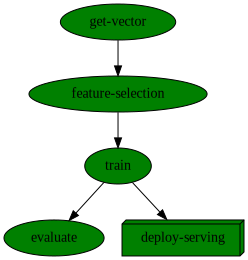

uid,start,state,kind,name,parameters,results
...f8fcc251,Oct 08 13:21:44,completed,run,evaluate,label_columns=labelmodel=store://artifacts/fraud-demo-felipe/transaction_fraud_rf:latest@e27f0d6d-8f14-4642-abee-43b9867631efdrop_columns=label,evaluation_accuracy=0.9905evaluation_f1_score=0.17391304347826086evaluation_precision_score=0.4evaluation_recall_score=0.1111111111111111
...674058e1,Oct 08 13:21:10,completed,run,train,sample=-1label_column=labeltest_size=0.1,best_iteration=1accuracy=0.9905f1_score=0.17391304347826086precision_score=0.4recall_score=0.1111111111111111
...af1f9176,Oct 08 13:20:42,completed,run,feature-selection,output_vector_name=shortlabel_column=labelk=18min_votes=2ignore_type_errors=True,top_features_vector=store://feature-vectors/fraud-demo-felipe/short
...c1e2831f,Oct 08 13:20:21,completed,run,get-vector,"feature_vector=transactions-fraudfeatures=['events.*', 'transactions.amount_max_2h', 'transactions.amount_sum_2h', 'transactions.amount_count_2h', 'transactions.amount_avg_2h', 'transactions.amount_max_12h', 'transactions.amount_sum_12h', 'transactions.amount_count_12h', 'transactions.amount_avg_12h', 'transactions.amount_max_24h', 'transactions.amount_sum_24h', 'transactions.amount_count_24h', 'transactions.amount_avg_24h', 'transactions.es_transportation_sum_14d', 'transactions.es_health_sum_14d', 'transactions.es_otherservices_sum_14d', 'transactions.es_food_sum_14d', 'transactions.es_hotelservices_sum_14d', 'transactions.es_barsandrestaurants_sum_14d', 'transactions.es_tech_sum_14d', 'transactions.es_sportsandtoys_sum_14d', 'transactions.es_wellnessandbeauty_sum_14d', 'transactions.es_hyper_sum_14d', 'transactions.es_fashion_sum_14d', 'transactions.es_home_sum_14d', 'transactions.es_travel_sum_14d', 'transactions.es_leisure_sum_14d', 'transactions.gender_F', 'transactions.gender_M', 'transactions.step', 'transactions.amount', 'transactions.timestamp_hour', 'transactions.timestamp_day_of_week']label_feature=labels.labeltarget={'name': 'parquet', 'kind': 'parquet'}update_stats=True",return=


In [ ]:
import json
run_id = project.run(
    'main',
    arguments={'vector_name':"transactions-fraud",
               'features': json.dumps(features),
                'label_column':"labels.label",
              }, 
    dirty=True, watch=True, engine='remote')

## Test the model endpoint

Now that your model is deployed using the pipeline, you can invoke it as usual:

In [ ]:
# Define your serving function
serving_fn = project.get_function('serving')

# Choose an id for your test
sample_id = 'C1000148617'
model_inference_path = '/v2/models/fraud/infer'

# Send your sample ID for predcition
serving_fn.invoke(path=model_inference_path,
                  body={'inputs': [[sample_id]]})

> 2024-10-08 13:41:17,914 [info] Invoking function: {"method":"POST","path":"http://nuclio-fraud-demo-felipe-serving.default-tenant.svc.cluster.local:8080/v2/models/fraud/infer"}


{'id': 'c9b5036c-8957-48dc-adba-d7f60ccd7812',
 'model_name': 'fraud',
 'outputs': [0],
 'timestamp': '2024-10-08 13:41:17.934699+00:00',
 'model_version': 'latest'}

## Done!

You've completed part 4 - the model training with the feature store.
Proceed to [Part 5](06-real-time-serving-pipeline.ipynb) to learn how to deploy real-time application pipelines.